# 🐾 AnimalCLEF2025 Competition: Official Starter notebook

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Compute BAKS and BAUS

In [1]:
import numpy as np
from typing import List, Union

def baks_compute(
        y_true: Union[List, np.ndarray],
        y_pred: Union[List, np.ndarray],
        identity_test_only: Union[List, np.ndarray]
    ) -> float:
    """Computes BAKS (balanced accuracy on known samples).
    
    Focuses only on samples with known identities (not in identity_test_only).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        identity_test_only: Labels of unknown identities (only in test set)
        
    Returns:
        Balanced accuracy score for known samples
    """
    # Convert inputs to numpy arrays with object dtype to handle mixed types
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    identity_test_only = np.array(identity_test_only, dtype=object)
    
    # Filter out unknown samples
    mask = ~np.isin(y_true, identity_test_only)
    y_true_known = y_true[mask]
    y_pred_known = y_pred[mask]
    
    if len(y_true_known) == 0:
        return 0.0
    
    # Get unique classes in the filtered true labels
    unique_classes = np.unique(y_true_known)
    n_classes = len(unique_classes)
    
    # Compute per-class accuracy and average
    class_accuracies = []
    for cls in unique_classes:
        cls_mask = (y_true_known == cls)
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(y_pred_known[cls_mask] == cls)
            class_accuracies.append(cls_acc)
    
    # Return the balanced accuracy (mean of per-class accuracies)
    return np.mean(class_accuracies) if class_accuracies else 0.0

def baus_compute(
        y_true: Union[List, np.ndarray],
        y_pred: Union[List, np.ndarray],
        identity_test_only: Union[List, np.ndarray],
        new_class: Union[int, str]
    ) -> float:
    """Computes BAUS (balanced accuracy on unknown samples).
    
    Focuses only on samples with unknown identities (in identity_test_only).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        identity_test_only: Labels of unknown identities (only in test set)
        new_class: Label used for identifying unknown samples
        
    Returns:
        Balanced accuracy score for unknown samples
    """
    # Convert inputs to numpy arrays with object dtype to handle mixed types
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    identity_test_only = np.array(identity_test_only, dtype=object)
    
    # Filter to include only unknown samples
    mask = np.isin(y_true, identity_test_only)
    y_true_unknown = y_true[mask]
    y_pred_unknown = y_pred[mask]
    
    if len(y_true_unknown) == 0:
        return 0.0
    
    # Get unique unknown classes
    unique_unknown_classes = np.unique(y_true_unknown)
    
    # For each unknown class, check if they were correctly predicted as new_class
    class_accuracies = []
    for cls in unique_unknown_classes:
        cls_mask = (y_true_unknown == cls)
        if np.sum(cls_mask) > 0:
            # For unknown samples, correct prediction is new_class
            cls_acc = np.mean(y_pred_unknown[cls_mask] == new_class)
            class_accuracies.append(cls_acc)
    
    # Return the balanced accuracy (mean of per-class accuracies)
    return np.mean(class_accuracies) if class_accuracies else 0.0

In [2]:
def compute_geometric_mean(baks, baus):
    return np.sqrt(baks * baus)

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

In [3]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-yjvmquec
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-yjvmquec
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 959c6c01a8317ed4f162ebfdf4b5e63faad60228
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wildlife-datasets: filename=wildlife_datasets-1.0.5-py3-none-any.whl size=88208 sha256=22d86c5bcbdee37388321988a47cc8278fd11f9e7e75d19d3c01dd8514329165
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhribczu/wheels/c5/e9/19/815dc8ac1a073b6769942e201b8776a681537b3da4bc2c60ab
Successfully built wi

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [4]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [5]:
root = '/kaggle/input/animal-clef-2025'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

### 📊 Visualizing Data

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [6]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


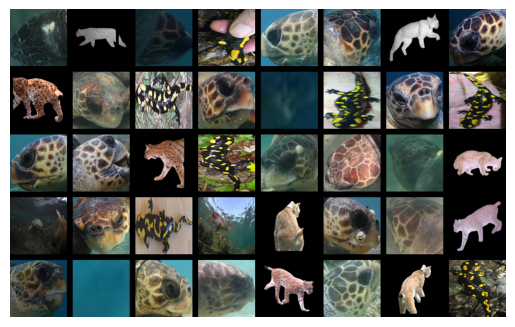

In [7]:
dataset.plot_grid()
dataset.metadata

This is confirmed by showing all datasets from which the data is composed of.

In [8]:
dataset.metadata[['dataset', 'split']].value_counts()

dataset           split   
SeaTurtleID2022   database    8729
LynxID2025        database    2957
SalamanderID2025  database    1388
LynxID2025        query        946
SalamanderID2025  query        689
SeaTurtleID2022   query        500
Name: count, dtype: int64

In [9]:
dataset.metadata[dataset.metadata['dataset'] == "SalamanderID2025"]

,image_id,identity,path,date,orientation,species,split,dataset
3903,3903,SalamanderID2025_2,images/SalamanderID2025/database/images/eafd41...,2017-06-03,top,NaN,database,SalamanderID2025
3904,3904,SalamanderID2025_2,images/SalamanderID2025/database/images/e80dc6...,2018-04-16,top,NaN,database,SalamanderID2025
3905,3905,SalamanderID2025_2,images/SalamanderID2025/database/images/836157...,2019-04-29,top,NaN,database,SalamanderID2025
3906,3906,SalamanderID2025_2,images/SalamanderID2025/database/images/8f4b82...,2018-04-16,top,NaN,database,SalamanderID2025
3907,3907,SalamanderID2025_3,images/SalamanderID2025/database/images/56d75a...,2017-07-08,top,NaN,database,SalamanderID2025
...,...,...,...,...,...,...,...,...
5975,5975,NaN,images/SalamanderID2025/query/images/f10a58d63...,2024-10-15,top,salamander,query,SalamanderID2025
5976,5976,NaN,images/SalamanderID2025/query/images/46d8af166...,2024-10-22,top,salamander,query,SalamanderID2025
5977,5977,NaN,images/SalamanderID2025/query/images/f7ca496bf...,2024-10-22,right,salamander,query,SalamanderID2025
5978,5978,NaN,images/SalamanderID2025/query/images/360912b59...,2024-10-23,right,salamander,query,SalamanderID2025


Now, we can plot the data of any dataset. Here we do it for the SeaTurtleID2022. The images are the same as in the query set. The goal for each image from the query set will be to determine its identity from the database (it will always be in the form `SeaTurtleID2022_t???` or to decide that it is a new individual (it is not present in the database).

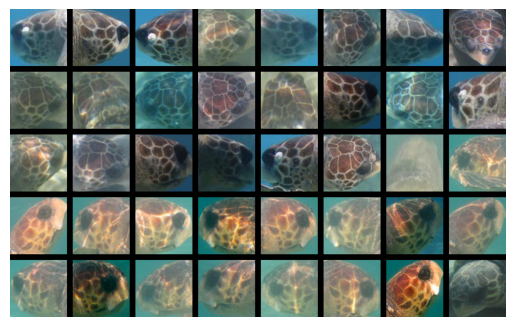

In [10]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

## Inference with MegaDescriptor

Instead of training a classifier, we can just use out of the shelf pretrained models - [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). We use MegaDescriptor to extract features from all images. 

**Note:** _It is highly recommended to use the GPU acceleration._

Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

# GET UNIQUE IDENTITIES

In [11]:
class FeatureWrapper:
    def __init__(self, features):
        self.features = features

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load metadata
metadata = pd.read_csv("/kaggle/input/animal-clef-2025/metadata.csv")  # Assuming metadata.csv contains image paths and labels
metadata.fillna('salamander', inplace=True)

# Separate database and query samples
database_samples = metadata[metadata["split"] == "database"]
query_samples = metadata[metadata["split"] == "query"]

# Extract unique identities
unique_identities = database_samples["identity"].unique()
len(unique_identities)

1102

In [13]:
from wildlife_datasets import datasets, splits
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)
df = dataset.df 
df = df[df['split'] == 'database']
df.species.value_counts()

species
loggerhead turtle    8729
lynx                 2957
Name: count, dtype: int64

In [14]:
df.fillna('salamander', inplace=True)
df.species.value_counts()

<ipython-input-14-05ec05b7b4b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('salamander', inplace=True)


species
loggerhead turtle    8729
lynx                 2957
salamander           1388
Name: count, dtype: int64

In [15]:
dataset = dataset.get_subset(df.index)

In [16]:
training_dataloader = dataset


training_dataloader.transform = T.Compose([
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.RandAugment(num_ops=2, magnitude=20),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
training_dataloader.transform

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandAugment(num_ops=2, magnitude=20, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

# Train a megadescriptor!
default code from [here](https://github.com/WildlifeDatasets/wildlife-tools/blob/main/baselines/training/MegaDescriptor-L-384.ipynb)

In [17]:
from itertools import chain
import torch
import timm
import pandas as pd
import torchvision.transforms as T
from torch.optim import SGD
from wildlife_tools.data import WildlifeDataset
from wildlife_tools.train import ArcFaceLoss, BasicTrainer

dataset_train = WildlifeDataset(
    metadata = training_dataloader.metadata, 
    root = root,
    transform=training_dataloader.transform
)

In [18]:
import torch
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus[0]

In [19]:
# Backbone and loss configuration
backbone = timm.create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224)
    embedding_size = backbone(dummy_input).shape[1]
objective = ArcFaceLoss(num_classes=dataset.num_classes, embedding_size=embedding_size, margin=0.5, scale=64)


# Optimizer and scheduler configuration
params = chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)
min_lr = optimizer.defaults.get("lr") * 1e-3
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=min_lr)
devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Setup training
trainer = BasicTrainer(
    dataset=dataset_train,
    model=backbone,
    device=0,
    objective=objective,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=8,
    accumulation_steps=8,
    num_workers=2,
    epochs=50,
)


trainer.train()

model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

Epoch 49: 100%|█████████████████████████████████████████████████| 1635/1635 [09:05<00:00,  3.00it/s]


In [20]:
trainer.save('model_trained')